<a href="https://colab.research.google.com/github/CryptoRobotFr/video-lfdm/blob/main/simple_super_trend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install python-binance ta

In [4]:
# Importation des librairies
import pandas as pd
from binance.client import Client
import ta
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np

# Variables pour les données
client = Client()
pair_symbol = "BTCUSDT"
time_interval = Client.KLINE_INTERVAL_2HOUR
start_date = "01 january 2017"

# Récupération des données
klinesT = client.get_historical_klines(pair_symbol, time_interval, start_date)

# Créer un tableau grâce aux données
df = pd.DataFrame(klinesT, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])

# Supprime les colonnes inutiles
df.drop(columns = df.columns.difference(['timestamp','open','high','low','close','volume']), inplace=True)

# Convertit les colonnes en numéric
for col in df.columns:
    df[col] = pd.to_numeric(df[col])

# Convertit les dates dans un format lisible
df = df.set_index(df['timestamp'])
df.index = pd.to_datetime(df.index, unit='ms')
del df['timestamp']

# Affiche le tableau
df

,open,high,low,close,volume
timestamp,,,,,
2017-08-17 04:00:00,4261.48,4328.69,4261.32,4315.32,70.415925
2017-08-17 06:00:00,4330.29,4349.99,4287.41,4349.99,11.672940
2017-08-17 08:00:00,4333.32,4445.78,4333.32,4444.00,11.736430
2017-08-17 10:00:00,4441.10,4485.39,4399.81,4427.30,51.883452
2017-08-17 12:00:00,4436.06,4459.00,4411.00,4459.00,54.344834
...,...,...,...,...,...
2022-02-13 04:00:00,42229.99,42333.24,42119.35,42268.49,633.372790
2022-02-13 06:00:00,42268.50,42490.01,42215.00,42412.40,1144.471250
2022-02-13 08:00:00,42412.39,42500.00,42269.64,42310.59,1008.686050


In [5]:
class SuperTrend():
    def __init__(
        self,
        high,
        low,
        close,
        atr_window=10,
        atr_multi=3
    ):
        self.high = high
        self.low = low
        self.close = close
        self.atr_window = atr_window
        self.atr_multi = atr_multi
        self._run()
        
    def _run(self):
        # calculate ATR
        price_diffs = [self.high - self.low, 
                    self.high - self.close.shift(), 
                    self.close.shift() - self.low]
        true_range = pd.concat(price_diffs, axis=1)
        true_range = true_range.abs().max(axis=1)
        # default ATR calculation in supertrend indicator
        atr = true_range.ewm(alpha=1/self.atr_window,min_periods=self.atr_window).mean() 
        # atr = ta.volatility.average_true_range(high, low, close, atr_period)
        # df['atr'] = df['tr'].rolling(atr_period).mean()
        
        # HL2 is simply the average of high and low prices
        hl2 = (self.high + self.low) / 2
        # upperband and lowerband calculation
        # notice that final bands are set to be equal to the respective bands
        final_upperband = upperband = hl2 + (self.atr_multi * atr)
        final_lowerband = lowerband = hl2 - (self.atr_multi * atr)
        
        # initialize Supertrend column to True
        supertrend = [True] * len(self.close)
        
        for i in range(1, len(self.close)):
            curr, prev = i, i-1
            
            # if current close price crosses above upperband
            if self.close[curr] > final_upperband[prev]:
                supertrend[curr] = True
            # if current close price crosses below lowerband
            elif self.close[curr] < final_lowerband[prev]:
                supertrend[curr] = False
            # else, the trend continues
            else:
                supertrend[curr] = supertrend[prev]
                
                # adjustment to the final bands
                if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
                    final_lowerband[curr] = final_lowerband[prev]
                if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
                    final_upperband[curr] = final_upperband[prev]

            # to remove bands according to the trend direction
            if supertrend[curr] == True:
                final_upperband[curr] = np.nan
            else:
                final_lowerband[curr] = np.nan
                
        self.st = pd.DataFrame({
            'Supertrend': supertrend,
            'Final Lowerband': final_lowerband,
            'Final Upperband': final_upperband
        })
        
    def super_trend_upper(self):
        return self.st['Final Upperband']
        
    def super_trend_lower(self):
        return self.st['Final Lowerband']
        
    def super_trend_direction(self):
        return self.st['Supertrend']


super_trend = SuperTrend(df['high'], df['low'], df['close'], 20, 7)
df['super_trend_upper'] = super_trend.super_trend_upper()
df['super_trend_lower'] = super_trend.super_trend_lower()
df['super_trend_direction'] = super_trend.super_trend_direction()

df

,open,high,low,close,volume,super_trend_upper,super_trend_lower,super_trend_direction
timestamp,,,,,,,,
2017-08-17 04:00:00,4261.48,4328.69,4261.32,4315.32,70.415925,NaN,NaN,True
2017-08-17 06:00:00,4330.29,4349.99,4287.41,4349.99,11.672940,NaN,NaN,True
2017-08-17 08:00:00,4333.32,4445.78,4333.32,4444.00,11.736430,NaN,NaN,True
2017-08-17 10:00:00,4441.10,4485.39,4399.81,4427.30,51.883452,NaN,NaN,True
2017-08-17 12:00:00,4436.06,4459.00,4411.00,4459.00,54.344834,NaN,NaN,True
...,...,...,...,...,...,...,...,...
2022-02-13 04:00:00,42229.99,42333.24,42119.35,42268.49,633.372790,NaN,40638.735289,True
2022-02-13 06:00:00,42268.50,42490.01,42215.00,42412.40,1144.471250,NaN,40638.735289,True
2022-02-13 08:00:00,42412.39,42500.00,42269.64,42310.59,1008.686050,NaN,40638.735289,True


In [10]:
initial_wallet = 1000 # Somme d'usd au début de la stratégie
taker_fee = 0.0007 # ~ 0.07% de frais sur binance et ftx 

# Initalisation de notre portefeuille
wallet = initial_wallet
usd = initial_wallet
coin = 0

# Initialisation de nos tableaux qui vont contenir nos données d'analyse
trades_hitory = []
days_history = []
previous_day = 0

# Simulation de notre stratégie en parcourant notre tableau ligne par ligne
for index, row in df.iterrows():

    # Garde en mémoire l'évolution de notre portefeuille chaque jour pour pouvoir analyser plus tard
    current_day = index.day
    if previous_day != current_day:
        temp_wallet = wallet
        if coin > 0:
            temp_wallet = coin*row['close']
        days_history.append({
            "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
            "wallet":temp_wallet,
            "price":row['close']
        })
    previous_day = current_day

    # Vérifie les conditions si l'on doit acheter
    if row['super_trend_direction'] == True and usd > 0:
        # Condition vérifiée, on achète à la clotûre
        coin = usd / row['close']           
        fee = taker_fee * coin             
        coin = coin - fee                   
        usd = 0                            
        wallet = coin * row['close']       
        # Ajout de données pour analyse future
        buy_data = {
            'date': index,
            'position': 'buy',
            'price': row['close'],
            'fee': fee * row['close'],
            'usd': usd,
            'coin': coin,
            'wallet': wallet
        }
        trades_hitory.append(buy_data) 

    # Vérifie les conditions si l'on doit vendre
    elif (row['super_trend_direction'] == False) and  coin > 0:
    # elif row['super_trend_direction'] == False and row['stoch_rsi'] > 0.2 and  coin > 0:
        # Condition vérifiée, on vend à la clotûre
        usd = coin * row['close']          
        fee = taker_fee * usd               
        usd = usd - fee                     
        coin = 0                           
        wallet = usd                      
        # Ajout de données pour analyse future
        buy_data = {
            'date': index,
            'position': 'sell',
            'price': row['close'],
            'fee': fee,
            'usd': usd,
            'coin': coin,
            'wallet': wallet           
        }
        trades_hitory.append(buy_data) 

# Convertit en tableau exploitable les données récupérer lors de la simulation
df_days = pd.DataFrame(days_history)
df_days['day'] = pd.to_datetime(df_days['day'])
df_days = df_days.set_index(df_days['day'])

df_trades = pd.DataFrame(trades_hitory)
df_trades['date'] = pd.to_datetime(df_trades['date'])
df_trades = df_trades.set_index(df_trades['date'])

In [11]:
df_trades

,date,position,price,fee,usd,coin,wallet
date,,,,,,,
2017-08-17 04:00:00,2017-08-17 04:00:00,buy,4315.32,0.700000,0.000000,0.231570,999.300000
2017-09-02 20:00:00,2017-09-02 20:00:00,sell,4299.53,0.696950,994.946554,0.000000,994.946554
2017-09-18 12:00:00,2017-09-18 12:00:00,buy,4090.00,0.696463,0.000000,0.243093,994.250092
2017-10-24 20:00:00,2017-10-24 20:00:00,sell,5450.02,0.927403,1323.933938,0.000000,1323.933938
2017-10-31 12:00:00,2017-10-31 12:00:00,buy,6329.04,0.926754,0.000000,0.209038,1323.007184
...,...,...,...,...,...,...,...
2021-11-08 00:00:00,2021-11-08 00:00:00,buy,65077.27,15.688022,0.000000,0.344141,22395.772434
2021-11-16 00:00:00,2021-11-16 00:00:00,sell,62110.10,14.962253,21359.684616,0.000000,21359.684616
2021-12-23 18:00:00,2021-12-23 18:00:00,buy,51109.99,14.951779,0.000000,0.417623,21344.732837


Period: [2017-08-17 00:00:00] -> [2022-02-13 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 21421.82 $
Performance vs US dollar: 2042.18 %
Worst Drawdown : -45.91%
Buy and hold performance: 878.69 %
Performance vs buy and hold: 118.88 %
Total trades on the period: 48
Global Win rate: 50.0 %
Average Profit: 8.5 %
Total fee: 379.9 $

Best trades: +101.9 % the 2019-06-04 02:00:00
Worst trades: -23.15 % the 2018-01-11 02:00:00

--- Plot wallet evolution vs asset ---


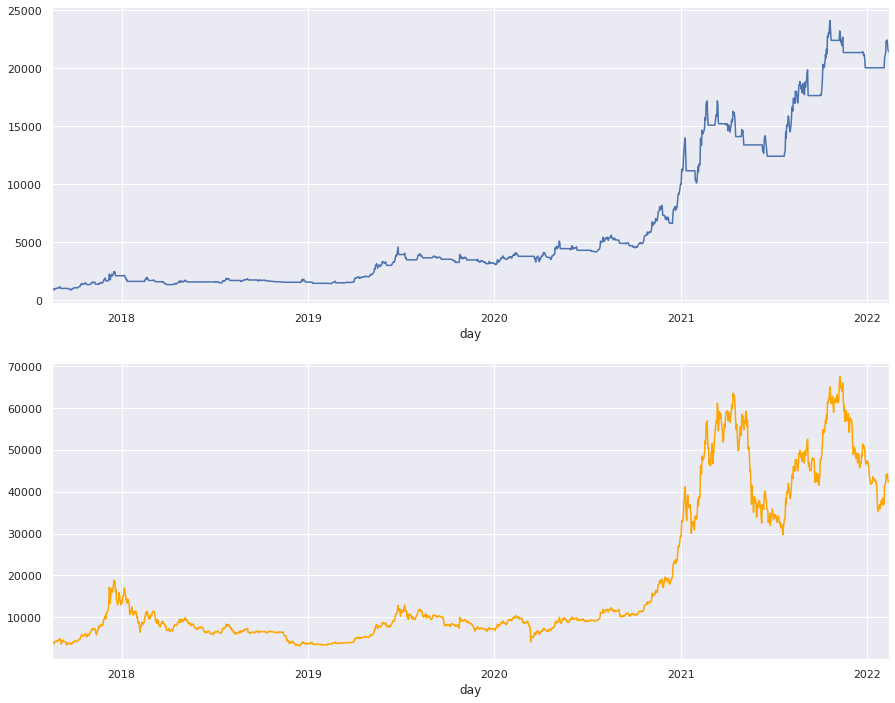

In [12]:
def plot_bar_by_month(df_days):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    custom_palette = {}
    
    last_month = int(df_days.iloc[-1]['day'].month)
    last_year = int(df_days.iloc[-1]['day'].year)
    
    current_month = int(df_days.iloc[0]['day'].month)
    current_year = int(df_days.iloc[0]['day'].year)
    current_year_array = []
    while current_year != last_year or current_month-1 != last_month:
        date_string = str(current_year) + "-" + str(current_month)
        
        monthly_perf = (df_days.loc[date_string]['wallet'].iloc[-1] - df_days.loc[date_string]['wallet'].iloc[0]) / df_days.loc[date_string]['wallet'].iloc[0]
        monthly_row = {
            'date': str(datetime.date(1900, current_month, 1).strftime('%B')),
            'result': round(monthly_perf*100)
        }
        if monthly_row["result"] >= 0:
            custom_palette[str(datetime.date(1900, current_month, 1).strftime('%B'))] = 'g'
        else:
            custom_palette[str(datetime.date(1900, current_month, 1).strftime('%B'))] = 'r'
        current_year_array.append(monthly_row)
        # print(monthly_perf*100) 
        if ((current_month == 12) or (current_month == last_month and current_year == last_year)):
            current_df = pd.DataFrame(current_year_array)
            # print(current_df)
            g = sns.barplot(data=current_df,x='date',y='result', palette=custom_palette)
            for index, row in current_df.iterrows():
                if row.result >= 0:
                    g.text(row.name,row.result, '+'+str(round(row.result))+'%', color='black', ha="center", va="bottom")
                else:
                    g.text(row.name,row.result, '-'+str(round(row.result))+'%', color='black', ha="center", va="top")
            g.set_title(str(current_year) + ' performance in %')
            g.set(xlabel=current_year, ylabel='performance %')
            
            year_result = (df_days.loc[str(current_year)]['wallet'].iloc[-1] - df_days.loc[str(current_year)]['wallet'].iloc[0]) / df_days.loc[str(current_year)]['wallet'].iloc[0]
            print("----- " + str(current_year) +" Cumulative Performances: " + str(round(year_result*100,2)) + "% -----")
            plt.show()

            current_year_array = []
        
        current_month += 1
        if current_month > 12:
            current_month = 1
            current_year += 1

def plot_wallet_vs_asset(df_days):
    fig, axes = plt.subplots(figsize=(15, 12), nrows=2, ncols=1)
    df_days['wallet'].plot(ax=axes[0])
    df_days['price'].plot(ax=axes[1], color='orange')

def show_analys(days, trades):
    df_trades = trades.copy()
    df_days = days.copy()

    df_days['evolution'] = df_days['wallet'].diff()
    df_trades['trade_result'] = df_trades['wallet'].diff()
    df_trades['trade_result_pct'] = df_trades['wallet'].pct_change()

    df_days['wallet_ath'] = df_days['wallet'].cummax()
    df_days['drawdown'] = df_days['wallet_ath'] - df_days['wallet']
    df_days['drawdown_pct'] = df_days['drawdown'] / df_days['wallet_ath']

    initial_wallet = df_days.iloc[0]["wallet"]

    close_trades = df_trades.loc[df_trades['position'] == 'sell']
    good_trades = close_trades.loc[close_trades['trade_result_pct'] > 0]
    total_trades = len(close_trades)
    total_good_trades = len(good_trades)
    avg_profit = close_trades['trade_result_pct'].mean() 
    global_win_rate = total_good_trades / total_trades
    max_days_drawdown = df_days['drawdown_pct'].max()
    final_wallet = df_days.iloc[-1]['wallet']
    buy_and_hold_pct = (df_days.iloc[-1]['price'] - df_days.iloc[0]['price']) / df_days.iloc[0]['price']
    buy_and_hold_wallet = initial_wallet + initial_wallet * buy_and_hold_pct
    vs_hold_pct = (final_wallet - buy_and_hold_wallet)/buy_and_hold_wallet
    vs_usd_pct = (final_wallet - initial_wallet)/initial_wallet
    total_fee = df_trades['fee'].sum()

    best_trade = df_trades['trade_result_pct'].max()
    best_trade_date =  str(df_trades.loc[df_trades['trade_result_pct'] == best_trade].iloc[0]['date'])
    worst_trade = df_trades['trade_result_pct'].min()
    worst_trade_date =  str(df_trades.loc[df_trades['trade_result_pct'] == worst_trade].iloc[0]['date'])

    print("Period: [{}] -> [{}]".format(df_days.iloc[0]["day"], df_days.iloc[-1]["day"]))
    print("Initial wallet: {} $".format(round(initial_wallet,2)))

    print("\n--- General Information ---")
    print("Final wallet: {} $".format(round(final_wallet,2)))
    print("Performance vs US dollar: {} %".format(round(vs_usd_pct*100,2)))
    print("Worst Drawdown : -{}%".format(round(max_days_drawdown*100, 2)))
    print("Buy and hold performance: {} %".format(round(buy_and_hold_pct*100,2)))
    print("Performance vs buy and hold: {} %".format(round(vs_hold_pct*100,2)))
    print("Total trades on the period: {}".format(total_trades))
    print("Global Win rate: {} %".format(round(global_win_rate*100, 2)))
    print("Average Profit: {} %".format(round(avg_profit*100, 2)))
    print("Total fee: {} $".format(round(total_fee, 2)))

    print("\nBest trades: +{} % the {}".format(round(best_trade*100, 2), best_trade_date))
    print("Worst trades: {} % the {}".format(round(worst_trade*100, 2), worst_trade_date))

# Fonction pour afficher une analyse complète de la stratégie sur le passé
show_analys(df_days.loc["2017":], df_trades.loc["2017":])

print("\n--- Plot wallet evolution vs asset ---")
# Fonction pour afficher une analyse complète de la stratégie sur le passé
plot_wallet_vs_asset(df_days.loc["2017":])

----- 2017 Cumulative Performances: 108.85% -----


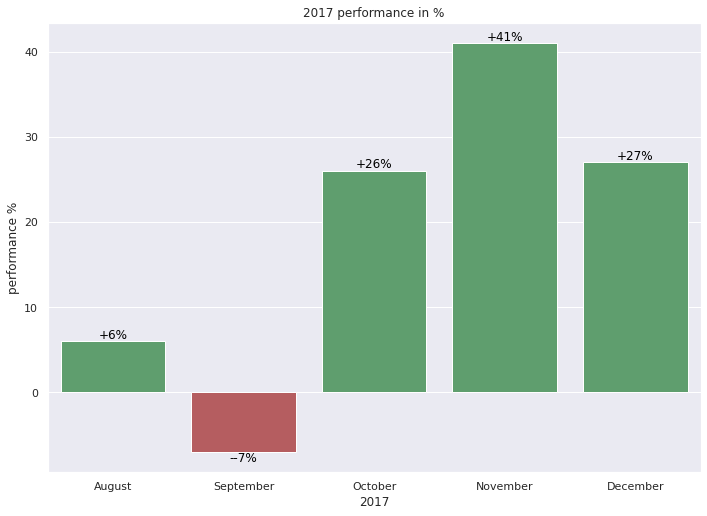

----- 2018 Cumulative Performances: -26.09% -----


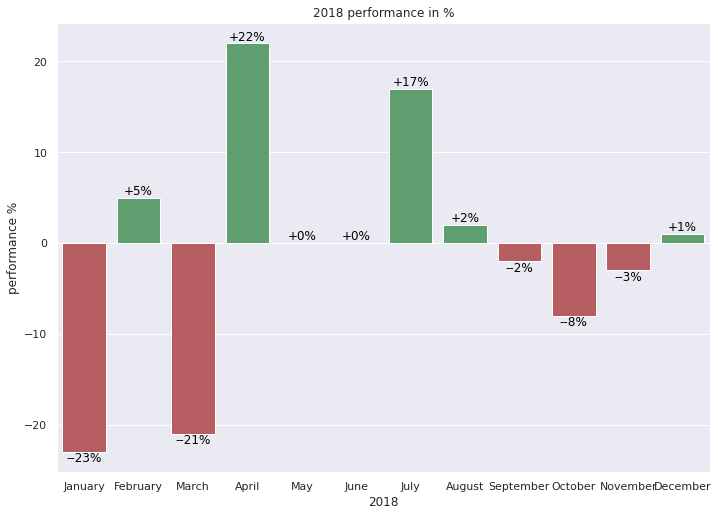

----- 2019 Cumulative Performances: 106.46% -----


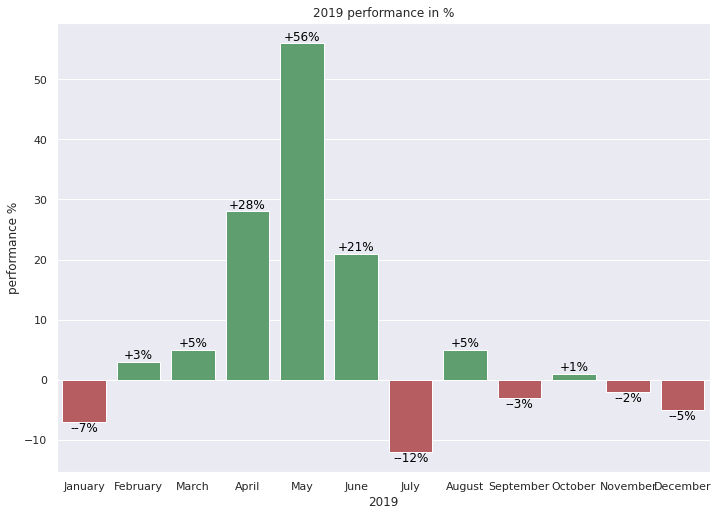

----- 2020 Cumulative Performances: 208.84% -----


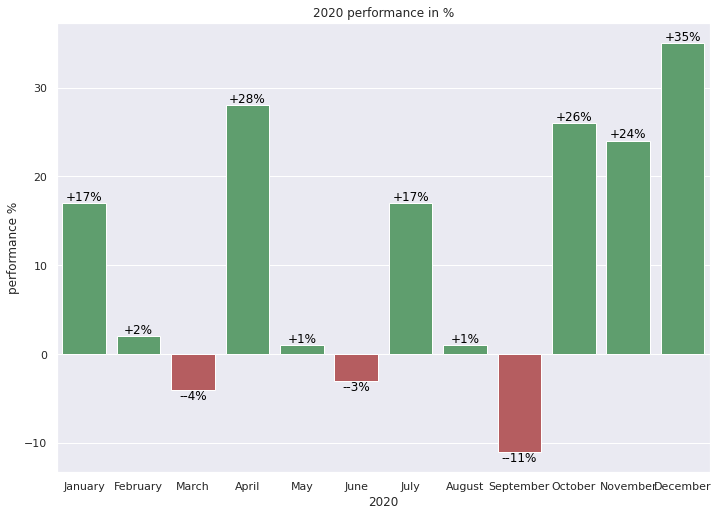

----- 2021 Cumulative Performances: 100.38% -----


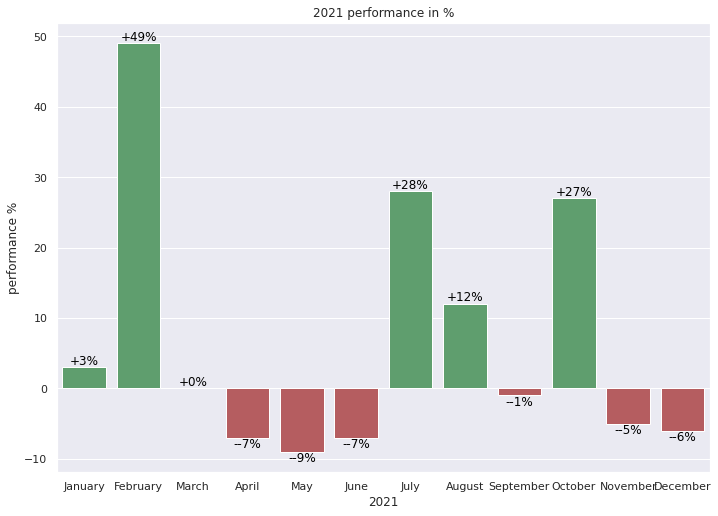

----- 2022 Cumulative Performances: 6.87% -----


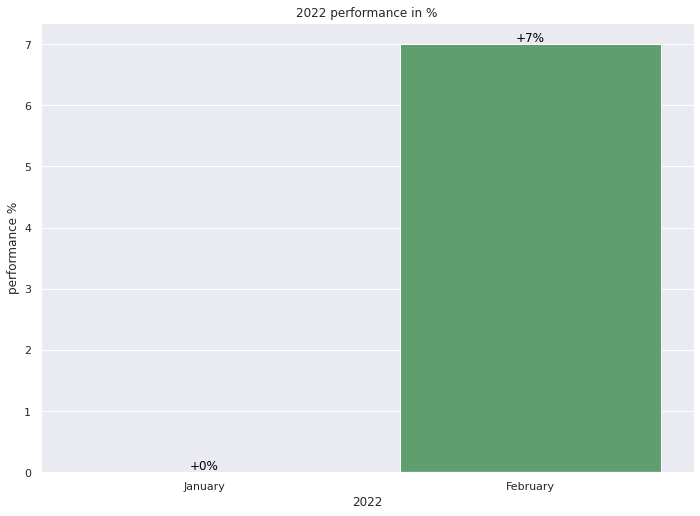

In [13]:
# Fonction pour afficher les gains et les pertes mois par mois
plot_bar_by_month(df_days.loc[:])